#### ECON 323: QUANTECON MODELLING WITH DATA SCIENCE APPLICATIONS

#### Machine Learning Techniques for the Prediction of Obesity among adults in the US

## INTRODUCTION

In this project, my aim is to use data from the National Health and Nutrition Examination Survey (NHANES) and predict the likelihood of a US adult being obese. Since my target is an "either or" variable, I use Machine Learning Classification Models to split the data into training and testing sets, build models on the training set and use the testing set to predict the likelihood of obesity. According to the CDC, an obese person is someone with a Body Mass Index of 30 or higher. Hence, the data used here are only for adults with a BMI greater than 29.

The specific models I will employ are Logistic Regression, Decision Trees and Random Forest. 

Finally, I shall use "accuracy" and Receiver Operating Charactersitic (ROC) to measure the models' performance and compare them to determine which one did best in predicting Obesity.

#### PACKAGE INSTALLATION

In [436]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in c:\jupyter\lib\site-packages (0.22.2.post1)
Note: you may need to restart the kernel to use updated packages.


#### LOADING NECESSARY PACKAGES

- I start off by loading all the necessary packages for my analysis.

In [725]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import DecisionTreeClassifier
from pydot import graph_from_dot_data
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import r2_score
from rfpimp import permutation_importances
import warnings
warnings.filterwarnings('ignore')
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
from sklearn.impute import SimpleImputer

### DATA EXPLORATION

 Having imported the data, I now conduct some Exploratory Data Analysis (EDA)
 to find patterns when and where they exist. This also involves cleaning the data,
 visualizing, creating dummies and pairplots.

In [726]:
nhanes1 = pd.read_excel('C:/nhanes data.xlsx')

print(nhanes1.shape)
print(list(nhanes1.columns))

(3834, 20)
['Unnamed: 0', 'SEQN', 'gender', 'age', 'race', 'foreign_born', 'education', 'poverty_ratio', 'Tot_Chol', 'BMI', 'Unnamed: 10', 'Blood_Pressure', 'obese', 'MaritalStatus', 'SleepTrouble', 'PhysActive', 'Smoke100n', 'SexEver', 'Diabetes', 'UrineVol1']


In [727]:
# Here, I filled missing values of the continuous variable with their mean values
mean_value = nhanes1[['Tot_Chol', 'Blood_Pressure', 'UrineVol1']].mean()
nhanes1[['Tot_Chol', 'Blood_Pressure','UrineVol1']]=nhanes1[['Tot_Chol', 'Blood_Pressure','UrineVol1' ]].fillna(mean_value)
nhanes1.head()

Unnamed: 0   SEQN  gender  age   race  foreign_born          education  \
0           1  83732    Male   62  White      USA_Born     College_Degree   
1           2  83733    Male   53  White  Foreign_Born  No_College_Degree   
2           3  83735  Female   56  White      USA_Born     College_Degree   
3           4  83736  Female   42  Blakc      USA_Born  No_College_Degree   
4           5  83741    Male   22  Blakc      USA_Born  No_College_Degree   

   poverty_ratio    Tot_Chol    BMI  Unnamed: 10  Blood_Pressure obese  \
0           4.39  113.000000  113.0          NaN           101.1    No   
1           1.32  113.000000  113.0          NaN           107.9   Yes   
2           5.00  113.000000  113.0          NaN           110.1   Yes   
3           1.23  105.346124   20.3          NaN            80.4    No   
4           2.08  112.000000   28.0          NaN            86.6    No   

  MaritalStatus SleepTrouble PhysActive Smoke100n SexEver Diabetes  UrineVol1  
0       Married          Yes         No    Smoker     Yes       No   352.0000  
1       Married          Yes         No    Smoker     Yes       No   352.0000  
2       Married          Yes         No    Smoker     Yes       No   352.0000  
3           NaN          NaN        NaN       NaN     NaN       No   124.6465  
4   LivePartner          Yes         No    Smoker     Yes       No    77.0000

In [728]:
# Select Variables 
nhanes1 = nhanes1[[ 'gender', 'age', 'race', 'foreign_born', 'education', 'poverty_ratio', 'Tot_Chol', 
                   'Blood_Pressure', 'obese', 'MaritalStatus', 'SleepTrouble', 'PhysActive', 'Smoke100n',
                   'SexEver', 'Diabetes', 'UrineVol1']]

In [729]:
nhanes1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 16 columns):
gender            3834 non-null object
age               3834 non-null int64
race              3834 non-null object
foreign_born      3834 non-null object
education         3834 non-null object
poverty_ratio     3834 non-null float64
Tot_Chol          3834 non-null float64
Blood_Pressure    3834 non-null float64
obese             3834 non-null object
MaritalStatus     2794 non-null object
SleepTrouble      3018 non-null object
PhysActive        3208 non-null object
Smoke100n         2795 non-null object
SexEver           2215 non-null object
Diabetes          3772 non-null object
UrineVol1         3834 non-null float64
dtypes: float64(4), int64(1), object(11)
memory usage: 479.4+ KB


##### Visualizing the Target a little!

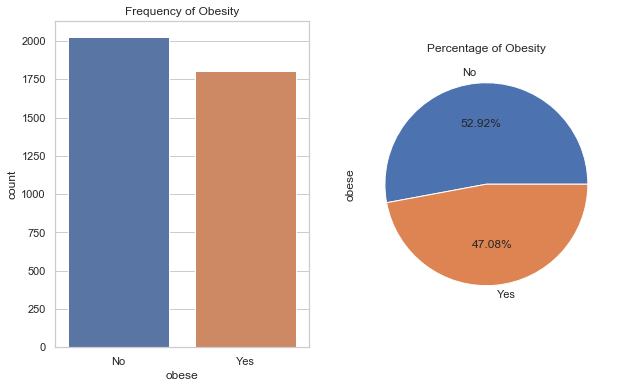

<Figure size 432x288 with 0 Axes>

In [677]:
fig, axs = plt.subplots(1,2,figsize=(10,6))
sns.countplot(x='obese',data=nhanes1,ax=axs[0])
axs[0].set_title("Frequency of Obesity")
nhanes1.obese.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of Obesity")
plt.show()
plt.savefig('count_plot')

It can be seen above that there are more normal than obese people based on the dataset

##### Computing Percentage of Obese and Normal People

In [678]:
count_normal = len(nhanes1[nhanes1['obese']=='No'])
count_obese = len(nhanes1[nhanes1['obese']=='Yes'])
pct_of_normal = count_normal/(count_normal+count_obese)
print("percentage of normal is", pct_of_normal*100)
pct_of_obese = count_obese/(count_normal+count_obese)
print("percentage of obese", pct_of_obese*100)

percentage of normal is 52.92123109024518
percentage of obese 47.07876890975483


The classes are only a little unbalanced and the ratio of normal to obese is about 53:47

In [679]:
nhanes1.groupby('obese').mean()

age  poverty_ratio    Tot_Chol  Blood_Pressure   UrineVol1
obese                                                                  
No     43.385904       2.539788   97.566230      107.535107  123.449053
Yes    46.170083       2.406609  114.091501      115.640908  125.992549

### Observations:

- Obese people are older on average
- They have higher blood pressure
- They fall below the poverty line on average, and
- They have higher Cholesterol intake


### VISUALIZATIONS
 
 To see the association of obesity with categorical factors, I use grouped bar graphs.

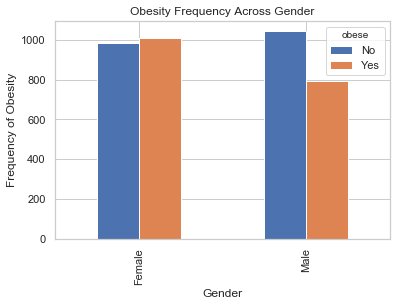

In [680]:
%matplotlib inline
pd.crosstab(nhanes1.gender,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Across Gender')
plt.xlabel('Gender')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_gender')

The proportion of females who are obese is higher than that of males.

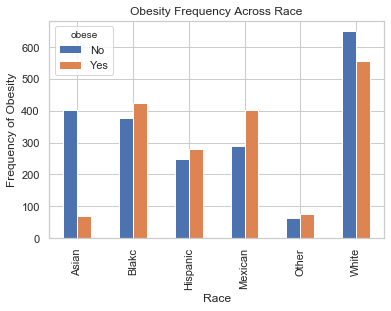

In [681]:
%matplotlib inline
pd.crosstab(nhanes1.race,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Across Race')
plt.xlabel('Race')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_race')


The frequency of obesity depends a great deal on race. 
Thus, race can be another good predictor of the outcome variable as well.

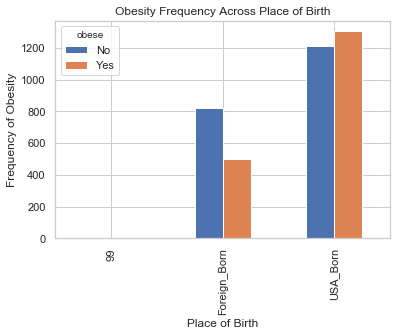

In [682]:

%matplotlib inline
pd.crosstab(nhanes1.foreign_born,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Across Place of Birth')
plt.xlabel('Place of Birth')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_pob')

POB can be another good predictor of the outcome variable.

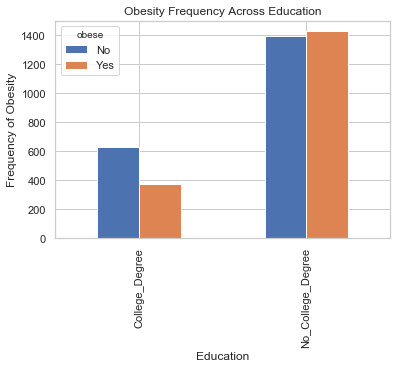

In [683]:
%matplotlib inline
pd.crosstab(nhanes1.education,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Across Education')
plt.xlabel('Education')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_edu')

The frequency of Obesity also depends of education. Hence, education could be another good predictor of the outcome variable.

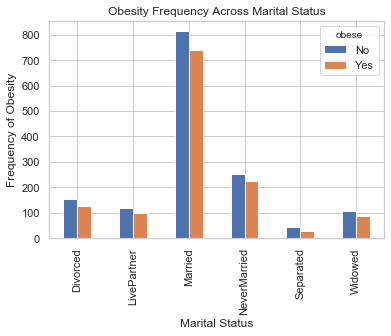

In [684]:
%matplotlib inline
pd.crosstab(nhanes1.MaritalStatus,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Across Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_edu')


The frequency of Obesity also depends of Marriage. Hence, Marriage could be another good predictor of the outcome variable.

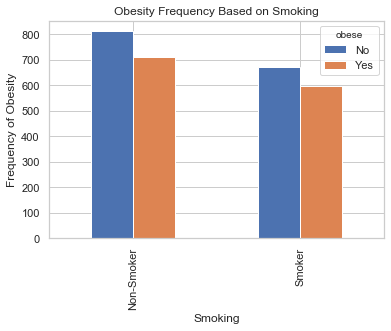

In [685]:
%matplotlib inline
pd.crosstab(nhanes1.Smoke100n,nhanes1.obese).plot(kind='bar')
plt.title('Obesity Frequency Based on Smoking')
plt.xlabel('Smoking')
plt.ylabel('Frequency of Obesity')
plt.savefig('obese_fre_edu')

##### CREATING DUMMY VARIABLES FOR CATEGORICALS AND RENAMING VARIABLES

In [730]:
nhanes1 = pd.get_dummies(nhanes1, columns = ['gender', 'race', 'foreign_born', 'education', 'obese', 'Diabetes',
                                             'MaritalStatus', 'SleepTrouble',
                                            'PhysActive', 'Smoke100n', 'SexEver'], 
              prefix_sep = '_', drop_first = True) # To avoid dummy variable trap in the estimation,I drop one variable!

nhanes1.rename(columns= {'foreign_born_Foreign_Born':'foreign_born',
                         'foreign_born_USA_Born':'USA_born', 'race_Blakc':'race_Black', 
                         'obese_Yes':'obese'}, inplace = True)


#### PAIRPLOT OF CONTINUOUS VARIABLES

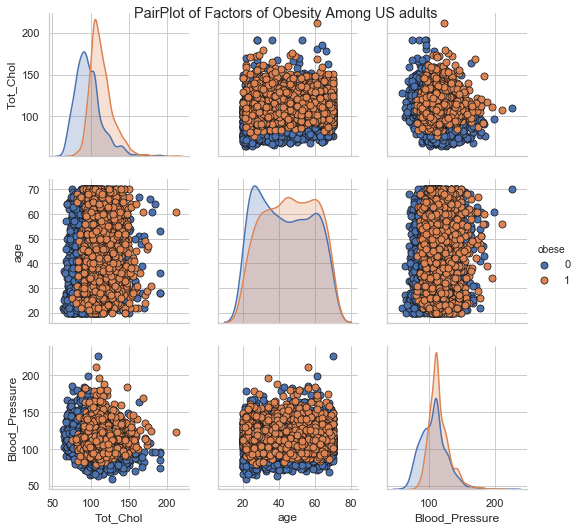

In [737]:
# Pairplot Colored by Incidence of Obesity
sns.pairplot(nhanes1, hue="obese", vars=["Tot_Chol", "age", "Blood_Pressure"], diag_kind = 'kde',
             plot_kws = { 's': 50, 'edgecolor': 'k'}
)

# Title
plt.suptitle('PairPlot of Factors of Obesity Among US adults');


#### Pairplot with Correlation Coefficients

I added the correlation coefficients since no clear relationship among most variables in the pairplot above

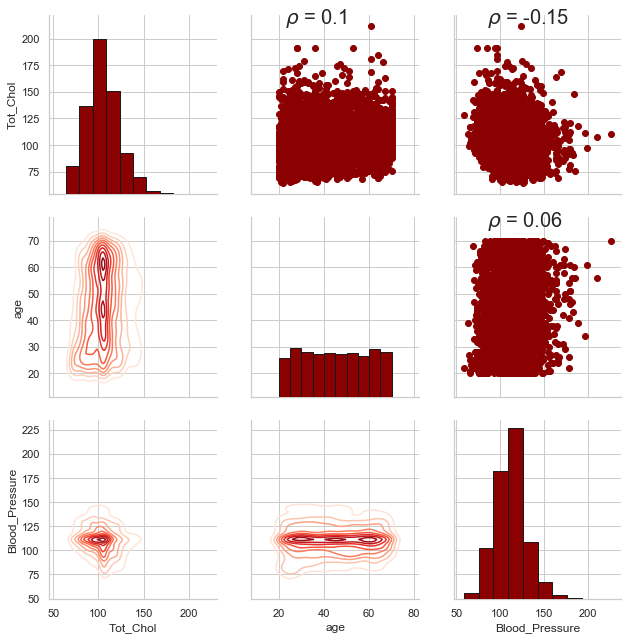

In [742]:
# Function to calculate correlation coefficient between two arrays
def corr(x, y, **kwargs):
    
    # Calculate the value
    coef = np.corrcoef(x, y)[0][1]
    # Make the label
    label = r'$\rho$ = ' + str(round(coef, 2))
    
    # Add the label to the plot
    ax = plt.gca()
    ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# Create a pair grid instance
grid = sns.PairGrid(data= nhanes1,
                    vars = ["Tot_Chol","age", "Blood_Pressure"], size = 3)

# Map the plots 
grid = grid.map_upper(plt.scatter, color = 'darkred')
grid = grid.map_upper(corr)
grid = grid.map_lower(sns.kdeplot, cmap = 'Reds')
grid = grid.map_diag(plt.hist, bins = 10, edgecolor =  'k', color = 'darkred');

### MODELLING

##### I start the modelling by Splitting the Data; I assign 70 percent to training and 30 percent to testing.

In [743]:
X = nhanes1.loc[:, nhanes1.columns != 'obese'] # Includes all features except the response
y = nhanes1.loc[:, nhanes1.columns == 'obese']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns
X_train.columns.values

array(['age', 'poverty_ratio', 'Tot_Chol', 'Blood_Pressure', 'UrineVol1',
       'gender_Male', 'race_Black', 'race_Hispanic', 'race_Mexican',
       'race_Other', 'race_White', 'foreign_born', 'USA_born',
       'education_No_College_Degree', 'Diabetes_Yes',
       'MaritalStatus_LivePartner', 'MaritalStatus_Married',
       'MaritalStatus_NeverMarried', 'MaritalStatus_Separated',
       'MaritalStatus_Widowed', 'SleepTrouble_Yes', 'PhysActive_Yes',
       'Smoke100n_Smoker', 'SexEver_Yes'], dtype=object)

#### RECURSIVE FEATURE ELIMINATION

In a bid to select the best features for my prediction, I use RFE.

In [744]:
data_final_vars=nhanes1.columns.values.tolist()
y=['obese']
X=[i for i in data_final_vars if i not in y]
logreg = LogisticRegression()
rfe = RFE(logreg, 20)
rfe = rfe.fit(X_train, y_train.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

[False  True  True  True False  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True  True False]
[5 1 1 1 4 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 1 1 2]


#### SELECT FEATURES

Based on the RFE output, I dropped age, total cholesterol, Sleep Trouble and Sex from my features.

In [745]:
feature_cols=['poverty_ratio', 'Tot_Chol', 'Blood_Pressure',
       'gender_Male', 'race_Black', 'race_Hispanic', 'race_Mexican',
       'race_Other', 'race_White', 'foreign_born', 'USA_born',
       'education_No_College_Degree', 'Diabetes_Yes',
       'MaritalStatus_LivePartner', 'MaritalStatus_Married',
       'MaritalStatus_NeverMarried', 'MaritalStatus_Separated',
       'MaritalStatus_Widowed',  'PhysActive_Yes',
       'Smoke100n_Smoker']
X=X_train[feature_cols]
y=y_train['obese']

#### LOGISTIC REGRESSION MODEL IMPLEMENTATION

Having Chosen the best predictors based on the RFE, I am ready to estimate the first model; Logit.

In [746]:
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                                Results: Logit
Model:                    Logit                  Pseudo R-squared:       inf   
Dependent Variable:       obese                  AIC:                    inf   
Date:                     2020-04-18 04:48       BIC:                    inf   
No. Observations:         2683                   Log-Likelihood:         -inf  
Df Model:                 19                     LL-Null:                0.0000
Df Residuals:             2663                   LLR p-value:            1.0000
Converged:                1.0000                 Scale:                  1.0000
No. Iterations:           7.0000                                               
-------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
--------------------------------------------------------

- Insignificant features (p-value > 0.05) are dropped from the dataset

In [747]:
feature_cols=[ 'Tot_Chol', 'Blood_Pressure', 
       'gender_Male', 'race_Black', 'race_Hispanic', 'race_Mexican',
       'race_Other', 'race_White', 'foreign_born', 'USA_born',
        'Diabetes_Yes',
       'MaritalStatus_Married',
        'MaritalStatus_Separated',
       'MaritalStatus_Widowed',  'PhysActive_Yes',
       'Smoke100n_Smoker']
X=X_train[feature_cols]
y=y_train['obese']
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: inf
         Iterations 7
                              Results: Logit
Model:                    Logit                Pseudo R-squared:     inf   
Dependent Variable:       obese                AIC:                  inf   
Date:                     2020-04-18 04:49     BIC:                  inf   
No. Observations:         2683                 Log-Likelihood:       -inf  
Df Model:                 15                   LL-Null:              0.0000
Df Residuals:             2667                 LLR p-value:          1.0000
Converged:                1.0000               Scale:                1.0000
No. Iterations:           7.0000                                           
---------------------------------------------------------------------------
                         Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------------------------------
Tot_Chol              

ODDS RATIO AND INTERPRETATION

In [748]:
np.exp(result.params)

Tot_Chol                   1.088069e+00
Blood_Pressure             1.058178e+00
gender_Male                5.538810e-01
race_Black                 3.369063e+00
race_Hispanic              4.670792e+00
race_Mexican               4.286018e+00
race_Other                 5.279163e+00
race_White                 2.169407e+00
foreign_born               1.559674e-07
USA_born                   1.901606e-07
Diabetes_Yes               5.737946e-01
MaritalStatus_Married      5.904796e-01
MaritalStatus_Separated    3.923355e-01
MaritalStatus_Widowed      2.678771e-01
PhysActive_Yes             7.805712e-01
Smoke100n_Smoker           7.719920e-01
dtype: float64

- The results imply that Obese people have higher intake of cholesterol;
- They also have higher Blood Pressure;
- The odds are higher among females than males, and
- Among people who are often not physically active.

#### LOGISTIC REGRESSION MODEL FITTING

I then use the Logistic Regression Function to fit the Model

In [749]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

##### Predicting Test results and Accuracy Calculation

In [750]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


##### Then out of Curiosity, I scaled the data to see if the accuracy improves!

In [751]:
from sklearn.preprocessing import scale
Xs = scale(X)
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, test_size=0.3, random_state=0)
logreg2 = LogisticRegression()
logreg2.fit(Xs_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [752]:
y_pred = logreg2.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg2.score(Xs_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.78


Lo and behold! It did not. So, I will maintain the logistic model with unscaled data

#### ROC CURVE

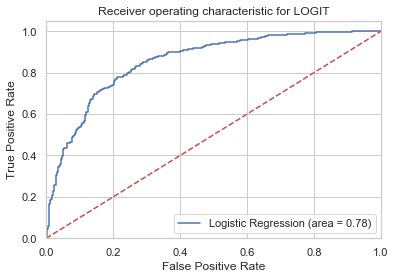

In [753]:
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for LOGIT')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

The bigger the area under the curve, the better. Hence, the logistic regression does a good job in predicting obesity than a random classifier.

#### DECISION TREE CLASSIFIER

Here, I use decision tree classifier to estimate the same training set and evaluate it similar to the logistic regression model.

##### Implementing Decision Tree 

In [754]:
# Create Decision Tree classifer object
dt = DecisionTreeClassifier()

# Train Decision Tree Classifer
dt_train = dt.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dt_train.predict(X_test)

##### Accuracy Measure

In [755]:
y_pred = dt_train.predict(X_test)
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dt_train.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.79


In [756]:
import os     

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

#### VISUALIZING THE DECISION TREE

In [757]:
dot_data = StringIO()
export_graphviz(dt_train, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('obese.png')
Image(graph.create_png())

- The Decision Tree is very large and hard to decipher, hence I pruned it below.

#### PRUNING THE DECISION TREE

In [758]:
# Create Decision Tree classifer object
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=3)

# Train Decision Tree Classifer
dt_clf = dt_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = dt_clf.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(dt_clf.score(X_test, y_test)))


Accuracy of Decision Tree classifier on test set: 0.83


- Notice that pruning the Decision Tree has improved its accuracy

#### Visualizing The Pruned Decision Tree

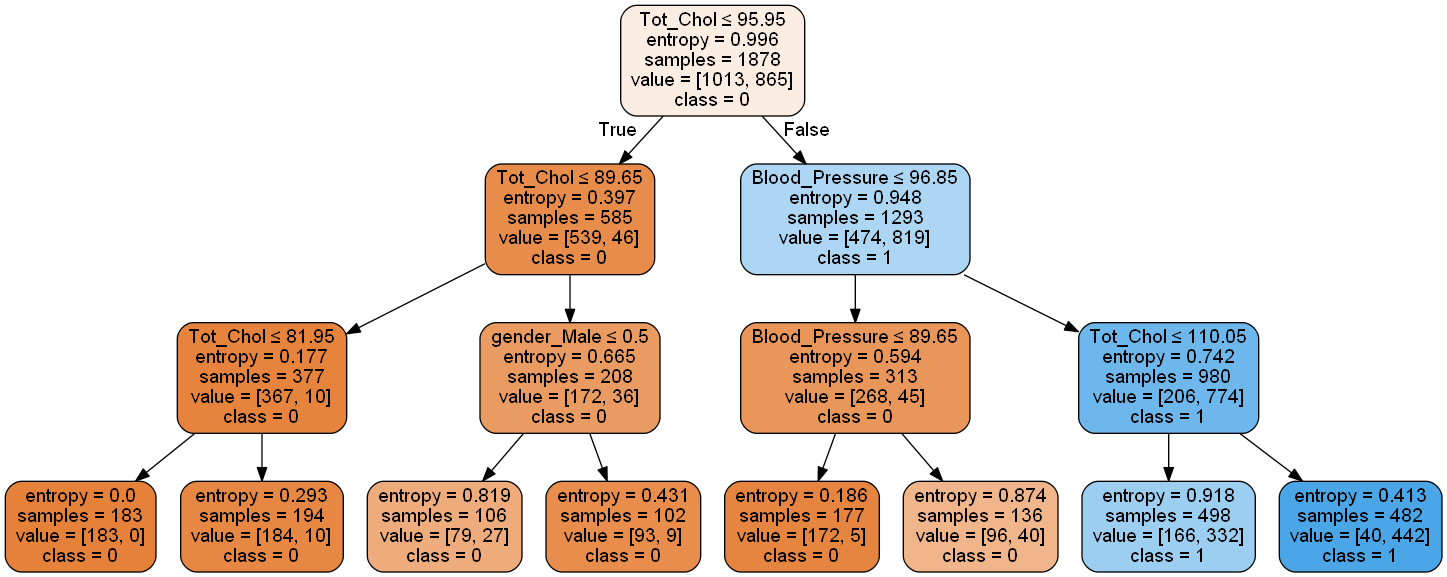

In [759]:
dot_data = StringIO()
export_graphviz(dt_clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('obese.png')
Image(graph.create_png())

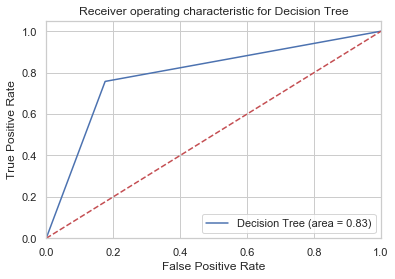

In [760]:
dt_roc_auc = roc_auc_score(y_test, dt_clf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, dt_train.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Decision Tree')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

#### RANDOM FOREST CLASSIFIER

- This is the final method I will use to estimate the incidence of Obesity.

##### Random Forest Model Implementation

In [761]:
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 40, max_features = 'sqrt')
# Train the model on training data
rf.fit(X_train, y_train);

##### Make Predictions!

In [762]:
# Actual class predictions
rf_predictions = rf.predict(X_test)
# Probabilities for each class
rf_probs = rf.predict_proba(X_test)[:, 1]

##### Accuracy Measurement

In [763]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'.format(rf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.85


#### ROC AUC

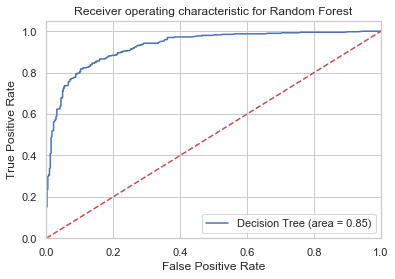

In [764]:
rf_roc_auc = roc_auc_score(y_test, rf.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Decision Tree (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for Random Forest')
plt.legend(loc="lower right")
plt.savefig('RF_ROC')
plt.show()

#### FEATURE IMPORTANCE PLOT

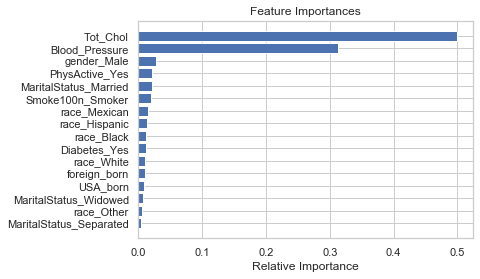

In [765]:
features = feature_cols
importances = rf.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### MODEL COMPARISON USING ROC_AUC
- Plotting all three ROCs to see the one with the biggest Area Under the Curve.

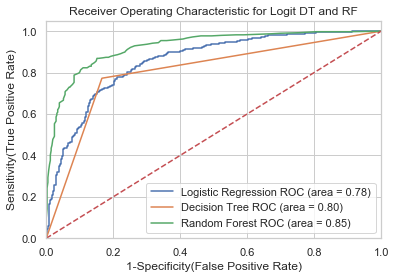

In [766]:
plt.figure()

# Adding Models to the list that I want to view on the ROC plot
models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(),
},
{
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier(),
},
    {
        'label': 'Random Forest',
        'model': RandomForestClassifier()
    }
]

# Below for loop iterates through the models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic for Logit DT and RF')
plt.legend(loc="lower right")
plt.show()   # Display

### CONCLUSION


- Based on the three Machine Learning Models employed on the NHANES dataset to predict the Incidence of Obesity among US adults, I find the Random Forest Model to be the best in terms of ROC and accuracy metrics.

- I also found that high Cholesterol intake, blood pressure and Gender are the most important variables in predicting Obesity.

##### Potential Weaknesses

- This analysis only considered data on adults, but Obesity does occur across all ages.

#### By:  Jallow Abdullah